### CHUNKING

**Importing libraries**

In [53]:
!pip install langchain langchain_experimental

In [54]:
!pip install -qU pypdf

In [55]:
!pip install openai

In [56]:
import langchain
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_experimental.text_splitter import SemanticChunker

In [57]:
#importing the document
doc = "/content/drive/MyDrive/10academy/contract rag/Raptor Contract.docx.txt"

In [58]:
#reading the file
with open(doc, 'r') as file:
    doc_content = file.read()

### CHUNKING

In [59]:
#initializing the recursive chunker
text_chunker = RecursiveCharacterTextSplitter(
    chunk_size = 512,
    chunk_overlap = 64,
    length_function = len,
)

In [60]:
#chunking the data
from langchain.document_loaders.pdf import PyPDFDirectoryLoader


In [61]:
pdf_folder_path = "/content/drive/MyDrive/10academy/contract rag/raptor_data"
loader = PyPDFDirectoryLoader(pdf_folder_path)
docs = loader.load()
#
print(len(docs))
#
print(docs[1].page_content)

73
TABLE
OF
CONTENTS
ARTICLE
I
DEFINITIONS;
CER TAIN
RULES
OF
CONSTRUCTION
2
Section
1.01
Definitions
2
Section
1.02
Certain
Matters
of
Construction
13
ARTICLE
II
PURCHASE
AND
SALE
OF
SHARES
AND
WARRANTS;
TREA TMENT 
OF
OPTIONS;
CLOSING.
14
Section
2.01
Purchase
and
Sale
of
Shares
14
Section
2.02
Purchase
Price
14
Section
2.03
The
Closing
14
Section
2.04
Closing
Payments.
15
Section
2.05
Closing
Deliveries
15
Section
2.06
Treatment
of
Options
16
Section
2.07
Purchase
Price
Adjustment
17
Section
2.08
Escrow
19
ARTICLE
III
REPRESENT ATIONS
AND
WARRANTIES
REGARDING
THE 
ACQUIRED
COMP ANIES.
19
Section
3.01
Organization
19
Section
3.02
Power
and
Authorization
20
Section
3.03
Authorization
of
Governmental
Authorities
20
Section
3.04
Noncontravention
20
Section
3.05
Capitalization
of
the
Acquired
Companies
21
Section
3.06
Financial
Matters
22
Section
3.07
Absence
of
Certain
Developments
22
Section
3.08
Debt;
Guarantees
24
Section
3.09
Assets
25
Section
3.10
Real
Property
25
Section
3.11
Inte

In [62]:
chunks = text_chunker.split_documents(docs)

In [63]:
from langchain.embeddings.openai import OpenAIEmbeddings

In [ ]:
llms

In [64]:
# Retrieve the OpenAI API key from the environment
import os
openai_api_key1 = os.getenv("OPENAI_API_KEY")

embedding = OpenAIEmbeddings(openai_api_key = openai_api_key1)

In [65]:
print(len(chunks))

526


### CREATING EMBEDDINGS

In [66]:
!pip install llama-index-embeddings-openai

In [67]:
import os
import openai
from getpass import getpass

In [68]:
#getting the openai key
os.environ["OPENAI_API_KEY"] = getpass("openai API Key:")

openai API Key:··········


### Creating the vector database

In [69]:
!pip install pinecone-Client

In [70]:
!pip install tiktoken

In [71]:
from pinecone import Pinecone

# Retrieve the OpenAI API key from the environment
api_key = os.getenv("PINECONE_API_KEY")

# configure client
pc = Pinecone(api_key=api_key)

In [72]:
#creating an index
import time
from pinecone import ServerlessSpec

index_name = 'contract1'
existing_indexes = [
    index_info["name"] for index_info in pc.list_indexes()
]

# creating index
if index_name not in existing_indexes:
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=1536,  # dimensionality of ada 002
        metric='cosine',
        spec=ServerlessSpec(
        cloud="aws",
        region="us-west-2"
    )

    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
time.sleep(1)
# view index stats
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1052}},
 'total_vector_count': 1052}

In [73]:
from langchain.vectorstores import Pinecone as PineconeVectorStore

In [74]:
import os
os.environ['PINECONE_API_KEY'] = PINECONE_API_KEY

In [75]:
docsearch=PineconeVectorStore.from_texts(
    [t.page_content for t in chunks],
    embedding,
    index_name=index_name
)

In [76]:
query = "Are there any conditions to the closing?"
answ = docsearch.similarity_search(query, k =4)

In [77]:
answ

[Document(page_content='after\nthe\nClosing\ncontinue\nto\nhave\ncoverage\nunder\nall\nof\nthe\nLiability\nPolicies\nwith \nrespect\nto\nevents\noccurring\nprior\nto\nthe\nClosing.\nSection\nII.22\nNo\nBrokers\n.\nNo\nAcquired\nCompany\nhas\nany\nLiability\nof\nany\nkind\nto,\nor\nis \nsubject\nto\nany\nclaim\nof,\nany\nbroker ,\nfinder\nor\nagent\nin\nconnection\nwith\nthe\nContemplated \nTransactions\nother\nthan\nthose\nwhich\nwill\nbe\nborne\nby\nthe\nSellers.\n-\n50\n-\n112923184_5'),
 Document(page_content='after\nthe\nClosing\ncontinue\nto\nhave\ncoverage\nunder\nall\nof\nthe\nLiability\nPolicies\nwith \nrespect\nto\nevents\noccurring\nprior\nto\nthe\nClosing.\nSection\nII.22\nNo\nBrokers\n.\nNo\nAcquired\nCompany\nhas\nany\nLiability\nof\nany\nkind\nto,\nor\nis \nsubject\nto\nany\nclaim\nof,\nany\nbroker ,\nfinder\nor\nagent\nin\nconnection\nwith\nthe\nContemplated \nTransactions\nother\nthan\nthose\nwhich\nwill\nbe\nborne\nby\nthe\nSellers.\n-\n50\n-\n112923184_5'),
 Document(

In [78]:
#creating a retriever
retriever = docsearch.as_retriever(k = 4)

In [79]:
from langchain.vectorstores import pinecone
import pinecone

### RAG FUSION

In [80]:
from operator import itemgetter

from langchain.chat_models import ChatOpenAI

from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough

In [81]:

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

In [82]:
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [83]:
import textwrap
def wrap_text(text, width=90): #preserve_newlines
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text

In [84]:
text_reply = chain.invoke(query)

print(wrap_text(text_reply))

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "input": "Are there any conditions to the closing?"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<context,question>] Entering Chain run with input:
{
  "input": "Are there any conditions to the closing?"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<context,question> > 4:chain:RunnablePassthrough] Entering Chain run with input:
{
  "input": "Are there any conditions to the closing?"
}
[chain/end] [1:chain:RunnableSequence > 2:chain:RunnableParallel<context,question> > 4:chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "output": "Are there any conditions to the closing?"
}
[chain/end] [1:chain:RunnableSequence > 2:chain:RunnableParallel<context,question>] s] Exiting Chain run with output:
[outputs]
[chain/start] [1:chain:RunnableSequence > 5:prompt:ChatPromptTemplate] Entering Prompt run with input:
[inputs]
[chain/end] [1:chain:RunnableSequence > 5:p

In [85]:
from langchain.schema.output_parser import StrOutputParser
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.prompts import ChatMessagePromptTemplate, PromptTemplate,ChatPromptTemplate

prompt = ChatPromptTemplate(input_variables=['original_query'],
                            messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[],
                                                                                        template='You are a helpful assistant that generates multiple search queries based on a single input query.')),
                                      HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['original_query'],
                                                                                      template='Generate multiple search queries related to: {question} \n OUTPUT (4 queries):'))])

In [86]:
generate_queries = (
    prompt | llm | StrOutputParser() | (lambda x: x.split("\n"))
)

In [87]:
from langchain.load import dumps, loads


def reciprocal_rank_fusion(results: list[list], k=60):
    fused_scores = {}
    for docs in results:
        # Assumes the docs are returned in sorted order of relevance
        for rank, doc in enumerate(docs):
            doc_str = dumps(doc)
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            previous_score = fused_scores[doc_str]
            fused_scores[doc_str] += 1 / (rank + k)

    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]
    return reranked_results

In [88]:
ragfusion_chain = generate_queries | retriever.map() | reciprocal_rank_fusion
langchain.debug = True

In [89]:
ragfusion_chain.input_schema.schema()

{'title': 'PromptInput',
 'type': 'object',
 'properties': {'question': {'title': 'Question', 'type': 'string'}}}

In [90]:
query1 = 'Is any of the Sellers bound by a non-competition covenant after the Closing?'

In [91]:
ragfusion_chain.invoke({"question": query1})

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "question": "Is any of the Sellers bound by a non-competition covenant after the Closing?"
}
[chain/start] [1:chain:RunnableSequence > 2:prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "question": "Is any of the Sellers bound by a non-competition covenant after the Closing?"
}
[chain/end] [1:chain:RunnableSequence > 2:prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
{
  "lc": 1,
  "type": "constructor",
  "id": [
    "langchain",
    "prompts",
    "chat",
    "ChatPromptValue"
  ],
  "kwargs": {
    "messages": [
      {
        "lc": 1,
        "type": "constructor",
        "id": [
          "langchain",
          "schema",
          "messages",
          "SystemMessage"
        ],
        "kwargs": {
          "content": "You are a helpful assistant that generates multiple search queries based on a single input query.",
          "additional_kwargs": {}
        }
      },
      {

[(Document(page_content='to\nany \nother\nclaims,\ndemands\nand\ncauses\nof\naction\nhereinabove\nspecified,\nbut\nonly\nto\nthe\nextent\nsuch\nsection\nis\napplicable\nto\nreleases\nsuch\nas\nthis\n \nSection\n6.07\n.\nSection\nI.01\nNonsolicitation\n.\n(a)\n[Reserved]\n19\n(b)\nFor\na\nperiod\nof\n12\nmonths\nfrom\nand\nafter\nthe\nClosing\nDate\n(the\n“\nRestricted \nPeriod\n”),\nthe\nSellers\nshall\nnot,\nand\nshall\nnot\npermit,\ncause\nor\nencourage\nany\nof\ntheir\nAffiliates\nto, \n(i)\nsolicit,\nlure\nor\nentice\naway ,\nor\nin\nany\nother\nmanner\npersuade\nor\nattempt\nto\npersuade,\nany \nPerson\nwho\nis'),
  0.06585580821434867),
 (Document(page_content='and\nother\nindividual\nservice \nproviders\nhave\nsigned\n(i)\neither\nan\noffer\nletter ,\nemployment\nagreement\nor\na\nconsulting\nagreement \nwith\nthe\napplicable\nAcquired\nCompany\nand\n(ii)\na\nconfidentiality ,\nnon-solicitation,\ninventions \nassignment\nagreement,\nor\nother\nsuch\nContractual\nObligation\nproh

In [92]:
from langchain.schema.runnable import RunnablePassthrough
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

full_rag_fusion_chain = (
    {
        "context": ragfusion_chain,
        "question": RunnablePassthrough()
    }
    | prompt
    | llm
    | StrOutputParser()
)

In [93]:
full_rag_fusion_chain.input_schema.schema()

{'title': 'RunnableParallel<context,question>Input',
 'type': 'object',
 'properties': {'question': {'title': 'Question', 'type': 'string'}}}

In [94]:
full_rag_fusion_chain.invoke({"question": query1})

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "question": "Is any of the Sellers bound by a non-competition covenant after the Closing?"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<context,question>] Entering Chain run with input:
{
  "question": "Is any of the Sellers bound by a non-competition covenant after the Closing?"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<context,question> > 3:chain:RunnablePassthrough] Entering Chain run with input:
{
  "question": "Is any of the Sellers bound by a non-competition covenant after the Closing?"
}
[chain/end] [1:chain:RunnableSequence > 2:chain:RunnableParallel<context,question> > 3:chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "question": "Is any of the Sellers bound by a non-competition covenant after the Closing?"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<context,question> > 4:chain:RunnableSequence] Entering Chain 

'Yes, the Sellers are bound by a non-competition covenant for a period of 12 months after the Closing Date.'

### RAG Evaluation

In [95]:
!pip install datasets

In [96]:
!pip install ragas

In [97]:
from datasets import Dataset
import pandas as pd

questions = ["Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties?",
             "Does any of the Sellers provide a representation with respect to any Tax matters related to the Company?",
             "How much is the escrow amount?",
             "Would the aggregate amount payable by the Buyer to the Sellers be affected if it is determined that the actual Closing Debt Amount is greater the estimated Closing Debut Amount?",
             "What is the purpose of the escrow?",
             " May the Escrow Amount serve as a recourse for the Buyer in case of breach of representations by the Company?",
             "Are Change of Control Payments considered a Seller Transaction Expense?"

 ]
ground_truths = [["Except in the case of fraud, the Sellers have no liability for breach of representations and warranties "],
                ["No. Only the Company provides such a representation."],
                ["The escrow amount is equal to $1,000,000."],
                 ["yes"],
                ["To serve as a recourse of the Buyer in case of post-closing adjustments of the purchase price."],
                 ["No"],
                 ["yes"]]


answers = []
contexts = []

# Inference
for query in questions:
  answers.append(chain.invoke(query))
  contexts.append([docs.page_content for docs in retriever.get_relevant_documents(query)])

# To dict
data1 = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truths": ground_truths
}

# Convert dict to dataset
dataset1 = Dataset.from_dict(data1)

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "input": "Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties?"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<context,question>] Entering Chain run with input:
{
  "input": "Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties?"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel<context,question> > 4:chain:RunnablePassthrough] Entering Chain run with input:
{
  "input": "Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties?"
}
[chain/end] [1:chain:RunnableSequence > 2:chain:RunnableParallel<context,question> > 4:chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "output": "Under what circumstances and to what extent the Sellers are responsible for a breach of re

In [98]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset1,
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
    raise_exceptions=False
)


df = result.to_pandas()

[chain/start] [1:chain:ragas evaluation] Entering Chain run with input:
{}
[chain/start] [1:chain:ragas evaluation > 2:chain:row 0] Entering Chain run with input:
{
  "question": "Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties?",
  "answer": "The Sellers are responsible for any breach or violation of the provisions of the representations and warranties in the agreement by any of their Affiliates or their Affiliates' actions. The waiver of any breach or violation by any party does not extend to any prior or subsequent breach or violation.",
  "contexts": [
    "of\nany\nor\nall\nof\nthe\nSellers,\nby\nthe \nSellers’\nRepresentative)\nagainst\nwhom\nthe\nwaiver\nis\nto\nbe\neffective.\nNo\nwaiver\nby\nany\nparty\nof \nany\nbreach\nor\nviolation\nof,\ndefault\nunder\nor\ninaccuracy\nin\nany\nrepresentation,\nwarranty\nor \ncovenant\nhereunder ,\nwhether\nintentional\nor\nnot,\nwill\nbe\ndeemed\nto\nextend\nto\nany\npr

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

[llm/end] [1:chain:ragas evaluation > 3:chain:row 1 > 7:chain:answer_relevancy > 8:llm:ChatOpenAI] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "{\"question\": \"Do the Sellers provide a representation with respect to Tax matters related to the Acquired Companies?\", \"noncommittal\": 0}",
        "generation_info": {
          "finish_reason": "stop",
          "logprobs": null
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "{\"question\": \"Do the Sellers provide a representation with respect to Tax matters related to the Acquired Companies?\", \"noncommittal\": 0}",
            "additional_kwargs": {}
          }
        }
      },
      {
        "text": "{\"question\": \"Do the Sellers provide a representa

In [109]:
df

,question,answer,contexts,ground_truths,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,Under what circumstances and to what extent th...,The Sellers are responsible for any breach or ...,"[of\nany\nor\nall\nof\nthe\nSellers,\nby\nthe ...","[Except in the case of fraud, the Sellers have...","Except in the case of fraud, the Sellers have ...",0.00,1.0,1.0,0.855856
1,Does any of the Sellers provide a representati...,"Yes, the Sellers provide a representation with...","[on\nTax\nMatters\n.\nThe\nBuyer ,\nthe\nAcqui...",[No. Only the Company provides such a represen...,No. Only the Company provides such a represent...,0.00,0.0,0.0,0.957326
2,How much is the escrow amount?,The escrow amount is to be deposited by the Bu...,[with \nthe\nEscrow\nAgreement\nor\n(ii)\nthe\...,"[The escrow amount is equal to $1,000,000.]","The escrow amount is equal to $1,000,000.",0.25,0.0,NaN,0.000000
3,Would the aggregate amount payable by the Buye...,"Yes, the aggregate amount payable by the Buyer...",[after\nthe\ncommencement\nof \nthe\nAccountin...,[yes],yes,1.00,1.0,1.0,0.984329
4,What is the purpose of the escrow?,The purpose of the escrow is to hold the Escro...,[with \nthe\nEscrow\nAgreement\nor\n(ii)\nthe\...,[To serve as a recourse of the Buyer in case o...,To serve as a recourse of the Buyer in case of...,1.00,1.0,1.0,0.999999
5,May the Escrow Amount serve as a recourse for...,"Yes, the Escrow Amount may serve as a recourse...",[with \nthe\nEscrow\nAgreement\nor\n(ii)\nthe\...,[No],No,0.00,1.0,0.0,0.925629
6,Are Change of Control Payments considered a Se...,"No, Change of Control Payments are not conside...",[Act).\n“\nChange\nof\nControl\nPayment\n”\nme...,[yes],yes,1.00,1.0,NaN,1.000000


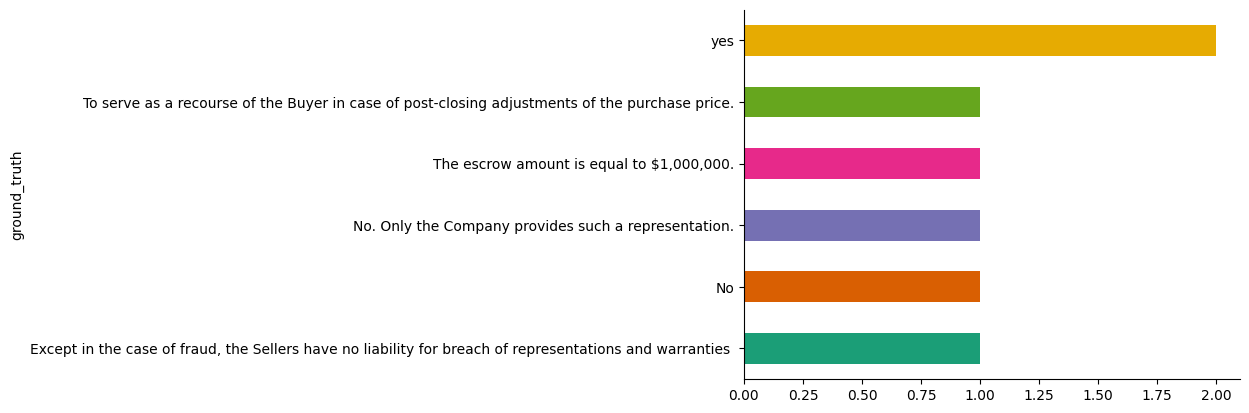

In [108]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('ground_truth').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

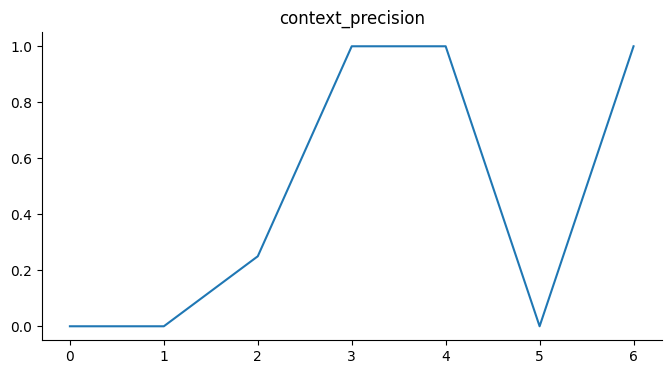

In [107]:
from matplotlib import pyplot as plt
df['context_precision'].plot(kind='line', figsize=(8, 4), title='context_precision')
plt.gca().spines[['top', 'right']].set_visible(False)

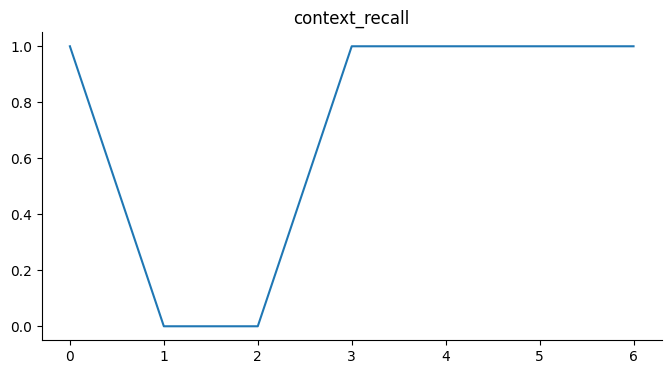

In [106]:
from matplotlib import pyplot as plt
df['context_recall'].plot(kind='line', figsize=(8, 4), title='context_recall')
plt.gca().spines[['top', 'right']].set_visible(False)

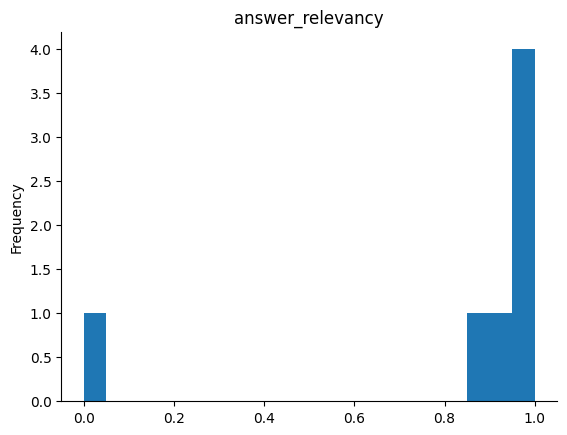

In [102]:
from matplotlib import pyplot as plt
df['answer_relevancy'].plot(kind='hist', bins=20, title='answer_relevancy')
plt.gca().spines[['top', 'right',]].set_visible(False)

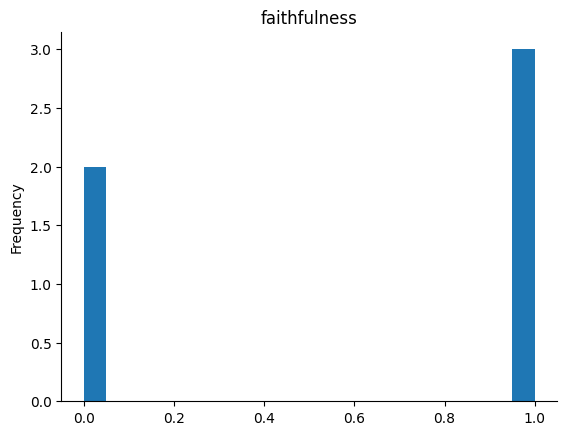

In [103]:
from matplotlib import pyplot as plt
df['faithfulness'].plot(kind='hist', bins=20, title='faithfulness')
plt.gca().spines[['top', 'right',]].set_visible(False)

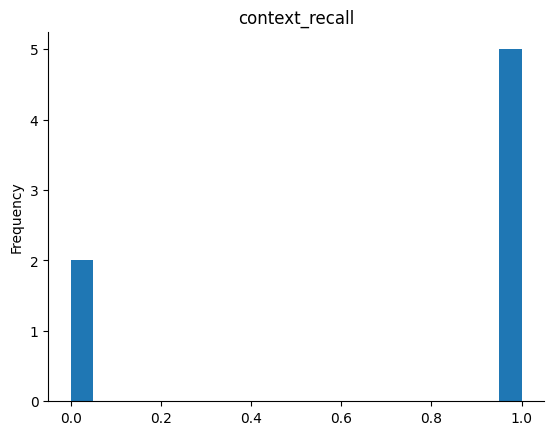

In [104]:
from matplotlib import pyplot as plt
df['context_recall'].plot(kind='hist', bins=20, title='context_recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

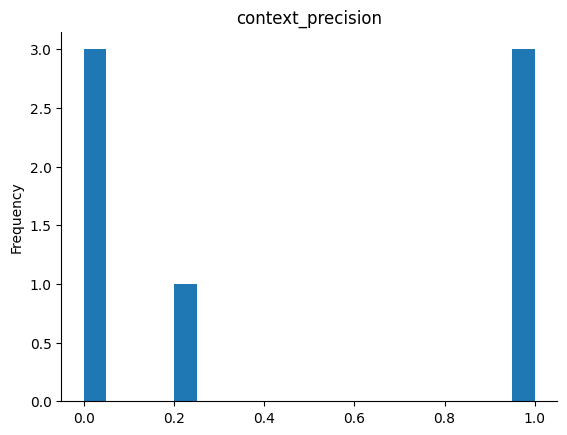

In [105]:
from matplotlib import pyplot as plt
df['context_precision'].plot(kind='hist', bins=20, title='context_precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

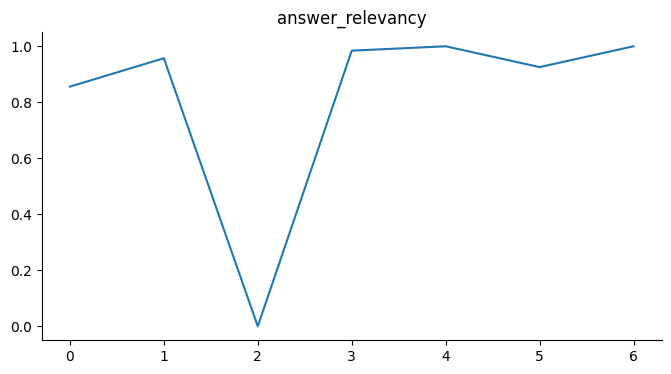

In [101]:
from matplotlib import pyplot as plt
df['answer_relevancy'].plot(kind='line', figsize=(8, 4), title='answer_relevancy')
plt.gca().spines[['top', 'right']].set_visible(False)

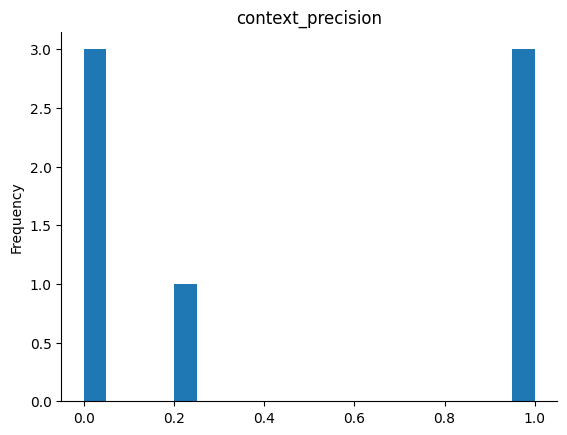

In [100]:
# context_precision

from matplotlib import pyplot as plt
df['context_precision'].plot(kind='hist', bins=20, title='context_precision')
plt.gca().spines[['top', 'right',]].set_visible(False)